# Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
# sns.set_theme('colorblind', color_codes=True)
sns.set_palette([*sns.color_palette("colorblind"), *sns.color_palette("dark")], color_codes=True)
# colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]
import pylab as pl

df = pd.read_csv('../data/all_merged_data_2021-01-22.csv')


checking on retail == all F2F

In [3]:
retail = df['Retail Closed']
f2f = df['All Face-to-Face Businesses Closed']

count = sum(retail != f2f)
# 0

In [4]:
df = df.drop(df.columns[5:], axis=1)
countries = ['Austria', 'England', 'Germany', 'Italy', 'Czech Republic', 'Switzerland', 'The Netherlands']

df = df.set_index(['Area', 'Date'])
df = df.sort_index(level=[0],ascending=[True])
df.reset_index(level=1, inplace=True)# df = df.sort_values(by=['Area'])
df.reset_index(level=0, inplace=True)# df = df.sort_values(by=['Area'])

In [5]:
from epimodel import preprocess_data
all_merged = preprocess_data('../data/all_merged_data_2021-01-22.csv', end_date='2021-01-22')
all_merged.featurize(drop_npi_filter = [
                {"query": "Childcare", "type": "includes"},
                {'query': 'Stay at Home Order AND All F2F Businesses Closed', 'type': 'equals'}
            ])
CMs = all_merged.CMs
Rs = all_merged.Rs
active_cms = all_merged.active_cms


Processing data from 2020-08-01 00:00:00 to 2021-01-22 00:00:00
Note: under drop_outdoor gathering aggregation, the gatherings_aggregation_type is disregarded


In [6]:
new_active = all_merged.active_cms.transpose((0, 2, 1))
new_active = new_active.reshape(-1, new_active.shape[2])
new_active = pd.DataFrame(new_active)
new_active.columns = all_merged.CMs



In [7]:
CM_dict = {
    'Some Face-to-Face Businesses Closed': 'Night clubs closed',
    'Leisure Venues Closed': 'Leisure and entertainment venues closed',
    'Gastronomy Closed': 'Gastronomy closed',
    'Retail Closed': 'Retail and close-contact services closed',
    'Primary Schools Closed': 'Primary schools closed',
    'Secondary Schools Closed': 'Secondary schools closed',
    'Universities Away': 'Universities closed',
    'Public Indoor Gathering Person Limit - 1': 'All public gatherings banned',
    'Public Indoor Gathering Person Limit - 2': 'Public gatherings limited to 2 people',
    'Extra Public Indoor Household Limit': 'Public gatherings limited to ≤10 people from 2 households',
    'Public Indoor Gathering Person Limit - 10': 'Public gatherings limited to ≤10 people',
    'Public Indoor Gathering Person Limit - 30': 'Public gatherings limited to ≤30 people',
    'Private Indoor Gathering Person Limit - 1': 'All household mixing in private banned',
    'Private Indoor Gathering Person Limit - 2': 'Household mixing in private limited to 2 people',
    'Extra Private Indoor Household Limit': 'Household mixing in private limited to ≤10 people from 2 households',
    'Private Indoor Gathering Person Limit - 10': 'Household mixing in private limited to ≤10 people',
    'Private Indoor Gathering Person Limit - 30': 'Household mixing in private limited to ≤30 people',
    'Curfew': 'Night time curfew',
    'Mandatory Mask Wearing >= 3': 'Stricter mask-wearing policy'
}


new_active.rename(columns=CM_dict, inplace=True)
CMs = list(CM_dict.values())
new_active = new_active[CMs]

In [8]:
df = pd.concat((df, new_active), axis=1)

## NPI representation by region


In [9]:
def count_active_days_region(npi, country):
    df_country = df[df['Country']==country]
    #non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
    non_zero_rows = df_country[df_country[npi] != 0]
    regions = np.unique(df_country['Area'])
    active_inds = []
    for region in regions:
        #active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
        #active_ind = df_country.loc[df_country['Area'] == region]
        active_rows = non_zero_rows[non_zero_rows['Area']==region]
        active_rows = active_rows[pd.to_datetime(active_rows['Date']) <= pd.to_datetime('2021-01-09')]
        count = active_rows.shape[0]
        active_inds.append(count)
    return regions, active_inds

active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]
active_days_cz = [count_active_days_region(npi, 'Czech')[1] for npi in CMs]
active_days_ch = [count_active_days_region(npi, 'Switzerland')[1] for npi in CMs]
active_days_nl = [count_active_days_region(npi, 'Netherlands')[1] for npi in CMs]
# summing up counts from the regions for each npi:
region_counts_uk = [sum(i) for i in active_days_uk]
region_counts_de = [sum(i) for i in active_days_de]
region_counts_at = [sum(i) for i in active_days_at]
region_counts_it = [sum(i) for i in active_days_it]
region_counts_cz = [sum(i) for i in active_days_cz]
region_counts_ch = [sum(i) for i in active_days_ch]
region_counts_nl = [sum(i) for i in active_days_nl]

In [10]:
region_counts = pd.DataFrame((region_counts_at, region_counts_uk,
region_counts_de, region_counts_it, region_counts_cz, region_counts_ch, region_counts_nl)).T
region_counts.index = CMs
region_counts.columns = countries


KeyboardInterrupt: 

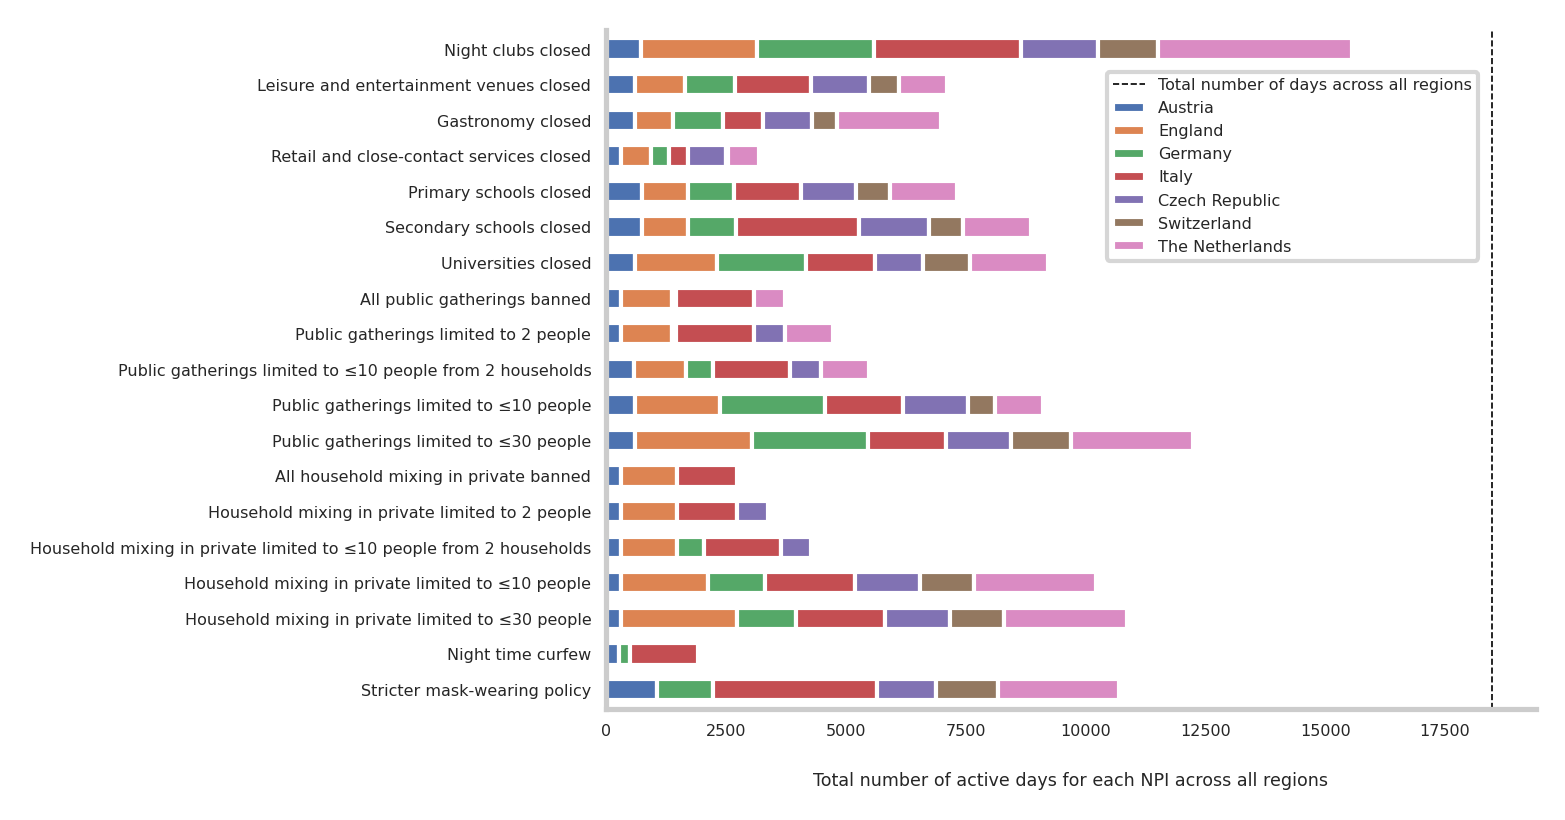

In [11]:
n_region_days = len(Rs)*162
sns.set(font_scale=0.35)
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=((4,3)), dpi=300)
ax = plt.gca()
ln1 = region_counts.plot.barh(stacked=True, ax = ax, width=0.6)
plt.title('Total number of active days for each NPI across all regions', y=-0.15)
ax.invert_yaxis()
ln2 = plt.axvline(x=n_region_days, color='black', linestyle='dashed', linewidth=0.4, label='Total number of days across all regions')
ax.tick_params(axis='both', which='major', length=0)
ax.grid(False)
sns.despine(right=True)
ax.legend(bbox_to_anchor=(0.53, 0.95))
plt.savefig('barplot.svg', format = 'svg', dpi=300, bbox_inches='tight')

In [ ]:
region_counts_normalised = region_counts.div(region_counts.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(region_counts_normalised, xticklabels = region_counts.columns, yticklabels = CMs, ax=ax).set_title('Active days attributable to each country')

In [ ]:
def plot_region_contribution_heatmap(active_days_specific_country, country):
    active_days_specific_country = pd.DataFrame(active_days_specific_country)
    active_days_specific_country.columns = count_active_days_region(CMs[0], country)[0]
    active_days_specific_country.index = CMs
    active_days_normalised = active_days_specific_country.div(active_days_specific_country.sum(axis=1), axis=0)
    return sns.heatmap(active_days_normalised, xticklabels = active_days_specific_country.columns, yticklabels = CMs).set_title('Proportion of active days in '+ country + ' attributable to each constituent region')

In [ ]:
plot_region_contribution_heatmap(active_days_uk, 'England')

In [ ]:
plot_region_contribution_heatmap(active_days_de, 'Germany')

In [ ]:
plot_region_contribution_heatmap(active_days_at, 'Austria')

In [ ]:
plot_region_contribution_heatmap(active_days_it, 'Italy')

In [ ]:
plot_region_contribution_heatmap(active_days_cz, 'Czech')

In [ ]:
plot_region_contribution_heatmap(active_days_ch, 'Switzerland')

In [ ]:
plot_region_contribution_heatmap(active_days_nl, 'Netherlands')

## Thresholding

In [ ]:
thresholding_CMs = [CM for CM in CMs if len(np.unique(df[CM]))>2]
df_reduced = df
df_thresholds = df_reduced[thresholding_CMs]
fig = plt.figure(figsize=((15,10)))
fig.subplots_adjust(hspace=1, wspace=1)
for i in range(len(thresholding_CMs)):
    ax = fig.add_subplot(3, 3, i+1)
    plt.xticks(rotation=70)
    sns.countplot(x = thresholding_CMs[i], data=df_thresholds, ax=ax)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs")
plt.show()

## Correlations

Correlations don't work when you have an npi always inactive or active for a region,
so instead this is a plot of proportion of region-days where the state of each npi is the same.

In [ ]:
def corr_region(region):
    df_region = df[df['Area'] == region].drop(columns=['Area', 'Date', 'Country', 'New Cases', 'New Deaths'])
    df_binary = (df_region > 0).astype(float)
    corr_mat = np.zeros((len(CMs), len(CMs)))
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            corr_mat[i, j] = np.sum(df_binary[CMs[i]] == df_binary[CMs[j]])/df_binary.shape[0]
    return corr_mat
def corr_country(country):
    df_country = df[df['Country'] == country]
    regions = list(set(df_country['Area']))
    return np.nanmean([corr_region(region) for region in regions], axis=0)
def corr_total():
    countries = list(set(df['Country']))
    return np.nanmean([corr_country(country) for country in countries], axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_total(), dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('Correlation plot, aggregated across countries')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Austria'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Austria: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('England'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('England: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Germany'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Germany: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Italy'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Italy: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Czech'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Czech: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Switzerland'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Switzerland: Correlation plot')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(corr_country('Netherlands'), dtype=float), xticklabels = CMs, yticklabels = CMs, ax = ax).set_title('Netherlands: Correlation plot')
plt.show()

## Conditional activation


In [ ]:
def get_active_dates_region(data, npi):
    non_zero_dates = data['Date'][data[npi] != 0]
    return non_zero_dates

def intersect_npi_active_dates_region(active_days_1, active_days_2):
    return set(active_days_1).intersection(set(active_days_2))

def proportional_activation_region(active_days_1, active_days_2):
    number_of_active_days = len(active_days_1)
    if number_of_active_days == 0: return float('nan')
    number_of_jointly_active_days = len(intersect_npi_active_dates_region(active_days_1, active_days_2))
    return number_of_jointly_active_days/number_of_active_days

def activation_difference_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2))

def only_one_active_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2)) + len(set(active_days_2) - set(active_days_1))

def find_conditional_activations(country):
    regions = np.unique(df['Area'][df['Country']==country])
    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    count = 0
    for region in regions:
        data = df[df['Area']==region]
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                active_days_1 = get_active_dates_region(data, CMs[i])
                active_days_2 = get_active_dates_region(data, CMs[j])
                if count == 0:
                    proportional_activations[i, j] = [proportional_activation_region(active_days_1, active_days_2)]
                    activation_differences[i, j] = [activation_difference_region(active_days_1, active_days_2)]
                    single_activations[i, j] = [only_one_active_region(active_days_1, active_days_2)]
                else:
                    proportional_activations[i, j].append(proportional_activation_region(active_days_1, active_days_2))
                    activation_differences[i, j].append(activation_difference_region(active_days_1, active_days_2))
                    single_activations[i, j].append(only_one_active_region(active_days_1, active_days_2))
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.mean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

def find_conditional_activations_total():

    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)

    countries = np.unique(df['Country'])
    count = 0
    for country in countries:
        prop, act, single = find_conditional_activations(country)
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                if count == 0:
                    proportional_activations[i, j] = [prop[i,j]]
                    activation_differences[i, j] = [act[i,j]]
                    single_activations[i, j] = [single[i,j]]
                else:
                    proportional_activations[i, j].append(prop[i,j])
                    activation_differences[i, j].append(act[i,j])
                    single_activations[i, j].append(single[i,j])
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.nanmean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

In [ ]:
prop, act, single = find_conditional_activations_total()

In [ ]:
fig = plt.figure(figsize=((10,30)))
fig.subplots_adjust(hspace=1)
ax = fig.add_subplot(3, 1, 1)
sns.heatmap(pd.DataFrame(prop, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(': Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
ax = fig.add_subplot(3, 1, 2)
sns.heatmap(pd.DataFrame(act, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(': Number of days where only NPI Y is active')
ax = fig.add_subplot(3, 1, 3)

In [ ]:
#calculate mean and min number of only one active
single[single==0] = float('NaN')
single[single>1000] = float('NaN')
single[single==366] = float('NaN')
single[single==450] = float('NaN')
single[single==585] = float('NaN')
single[single==601] = float('NaN')

print(np.nanmean(single), np.nanmin(single), np.where(single == np.nanmin(single)))

In [ ]:
#masks
schools_days = single[:8, :8]
print(np.nanmin(schools_days), np.where(schools_days == np.nanmin(schools_days)))
#2011 at schools, nice!

In [ ]:
#public private mean days
inout_days = []
for i, j in zip(range(8, 13), range(13,18)):
    inout_days.append(single[i, j])
for i, j in zip(range(18, 23), range(23,28)):
    inout_days.append(single[i, j])
print(np.mean(inout_days))
pubpriv_days = []
for i, j in zip(range(8, 18), range(18,28)):
    pubpriv_days.append(single[i, j])
print(np.mean(pubpriv_days))

In [ ]:
fig = plt.figure(figsize=((4,3)), dpi=300)
sns.set(font_scale=0.4)
sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs, cmap="BuPu_r")
plt.xticks(rotation=90)
plt.savefig('collinearity.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def conditional_activation_plotter(country):
    prop, act, single = find_conditional_activations(country)
    fig = plt.figure(figsize=((10,30)))
    fig.subplots_adjust(hspace=1)
    ax = fig.add_subplot(3, 1, 1)
    sns.heatmap(pd.DataFrame(prop, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
    ax = fig.add_subplot(3, 1, 2)
    sns.heatmap(pd.DataFrame(act, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Number of days where only NPI Y is active')
    ax = fig.add_subplot(3, 1, 3)
    sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Number of days where exactly one of NPI X and NPI Y is active')
    plt.show()


### Austria

In [ ]:
conditional_activation_plotter('Austria')

### England

In [ ]:
conditional_activation_plotter('England')

### Germany

In [ ]:
conditional_activation_plotter('Germany')

### Italy

In [ ]:
conditional_activation_plotter('Italy')

In [ ]:
conditional_activation_plotter('Czech')

In [ ]:
conditional_activation_plotter('Switzerland')

In [ ]:
conditional_activation_plotter('Netherlands')

## Paired Activation Differences

In [ ]:
def get_start_dates(data, npi, region):
    df_region = data[data['Area']==region]
    start_dates = []
    if list(df_region[npi])[0] != 0:
        start_dates.append(0)
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last == 0 and next != 0:
            start_dates.append(i)
        last = next
    return start_dates

def compare_dates(ds1, ds2):
    diffs = []
    for d1 in ds1:
        for d2 in ds2:
            diffs.append(d1 - d2)
    return diffs

def compute_start_dates(data):
    starts = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            starts[npi1, npi2] = []
            for region in np.unique(data['Area']):
                starts[npi1, npi2].append(compare_dates(get_start_dates(data, CMs[npi1], region),get_start_dates(data, CMs[npi2], region)))
            starts[npi1, npi2] = [diff for diffs in starts[npi1, npi2] for diff in diffs]
    return starts

def extract_diff_population(difference_data, threshold):
    count_data = np.zeros_like(difference_data)
    for i in range(count_data.shape[0]):
        for j in range(count_data.shape[1]):
            diff_reduced = [diff for diff in difference_data[i, j] if abs(diff) < threshold]
            count_data[i,j] = len(diff_reduced)
    return count_data

def get_end_dates(data, npi, region):
    df_region = data[data['Area']==region]
    end_dates = []
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last != 0 and next == 0:
            end_dates.append(i)
        last = next
    return end_dates

def compute_end_dates(data):
    ends = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            ends[npi1, npi2] = []
            for region in np.unique(data['Area']):
                ends[npi1, npi2].append(compare_dates(get_end_dates(data, CMs[npi1], region),get_end_dates(data, CMs[npi2], region)))
            ends[npi1, npi2] = [diff for diffs in ends[npi1, npi2] for diff in diffs]
    return ends

In [ ]:
starts = compute_start_dates(df)
# np.save('../data/npi_paired_activations', starts)

In [ ]:
ends = compute_end_dates(df)
# np.save('../data/npi_paired_deactivations', ends)

In [ ]:
starts_extracted = extract_diff_population(starts, 0.5)
sns.heatmap(pd.DataFrame(starts_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate at exactly the same time?')

In [ ]:
starts_extracted_5 = extract_diff_population(starts, 5)
sns.heatmap(pd.DataFrame(starts_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate within 5 days of each other?')

In [ ]:
ends_extracted = extract_diff_population(ends, 0.5)
sns.heatmap(pd.DataFrame(ends_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive at exactly the same time?')

In [ ]:
ends_extracted_5 = extract_diff_population(ends, 5)
sns.heatmap(pd.DataFrame(ends_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive within 5 days of each other?')

### Country-specific joint activation/deactivation

In [ ]:
df_uk = df[df['Country']=='England']
df_de = df[df['Country']=='Germany']
df_it = df[df['Country']=='Italy']
df_at = df[df['Country']=='Austria']
df_cz = df[df['Country']=='Czech']

In [ ]:
starts_uk = compute_start_dates(df_uk)
ends_uk = compute_end_dates(df_uk)
starts_de = compute_start_dates(df_de)
ends_de = compute_end_dates(df_de)
starts_it = compute_start_dates(df_it)
ends_it = compute_end_dates(df_it)
starts_at = compute_start_dates(df_at)
ends_at = compute_end_dates(df_at)
starts_cz = compute_start_dates(df_cz)
ends_cz = compute_end_dates(df_cz)
starts_countries = [starts_at, starts_uk, starts_de, starts_it, starts_cz]
ends_countries = [ends_at, ends_uk, ends_de, ends_it, ends_cz]

In [ ]:
def plot_joint_activation_heatmap(data, country, threshold, activate, ax):
    extracted = extract_diff_population(data, threshold)
    sns.heatmap(pd.DataFrame(extracted, dtype=float), xticklabels = CMs, yticklabels = CMs, ax=ax).set_title('On how many days across regions in '+ country + ' did each NPI pair '+activate+' within '+ str(threshold) + ' days of one another?')
def plot_all_joint_activation_heatmaps(threshold, activate = 'activate'):
    fig = plt.figure(figsize=((10,40)))
    fig.subplots_adjust(hspace=1)
    fig_number = 0
    for country in np.unique(df['Country']):
        fig_number += 1
        ax = fig.add_subplot(len(countries), 1, fig_number)
        if activate=='activate':
            data = starts_countries
        else:
            data = ends_countries
        plot_joint_activation_heatmap(data[fig_number-1], country, threshold, activate, ax = ax)
    plt.show()

In [ ]:
plot_all_joint_activation_heatmaps(0.5)

In [ ]:
plot_all_joint_activation_heatmaps(0.5, 'deactivate')

## Data figure

In [ ]:
def get_active_cms_region(region):
    df_region = df[df['Area']==region]
    df_region = np.array(df_region.drop(['Area', 'Date', 'Country', 'New Cases', 'New Deaths'], axis=1)).T
    return df_region

tester = get_active_cms_region('Nürnberg')

In [ ]:
def get_changes(region, CMs, Ds):
    region_index = Rs.index(region)
    changes = np.zeros((len(CMs), len(Ds)))
    active_CMs = get_active_cms_region(region)

    changes[:, 1:] = active_CMs[:, 1:] - active_CMs[:, :-1]

    all_starts = []
    all_ends = []
    for i, npi in enumerate(CMs):
        change = changes[i]
        starts = list(np.where(change == 1)[0])
        ends = list(np.where(change == -1)[0])

        if int(sum(active_CMs[i, :162])) == 162:
            if len(ends) > 0:
                starts.append(0)
            else:
                starts.append(0)
                ends.append(len(Ds) - 1)

        if len(starts) > 0:
            if len(ends) > 0:
                if ends[-1] < starts[-1]:
                    ends.append(len(Ds) - 1)
                if ends[0] < starts[0]:
                    starts.insert(0, 0)
            else:
                ends.append(len(Ds) - 1)
        if len(starts) != len(ends):
            print(npi, region, starts, ends)
        while len(starts) < 20:
            starts.append(200)
        while len(ends) < 20:
            ends.append(200)
        all_starts.append(starts)
        all_ends.append(ends)
    return np.array(all_starts), np.array(all_ends)


def add_pairs_to_plot(ax, starts, ends, index, CMs, alpha, width, size=8, plot_full=False, xmin=False):

    nCMs = len(CMs)

    y_vals = -1 * np.arange(nCMs)
    plt.plot([100], [100], linewidth=1, alpha=alpha)

    start = starts[:, index]
    end = ends[:, index]

    if plot_full:
        for cm in range(nCMs):
            line = ax.plot([0, 162], [y_vals[cm], y_vals[cm]], alpha=alpha, linewidth=width*2, label = CMs)
    else:
        lines = []
        for cm in range(nCMs):
            if xmin:
                lim = 116
                if start[cm] < lim and end[cm] < lim:
                    lines.append(ax.plot([0, 0], [y_vals[cm], y_vals[cm]], alpha=alpha, linewidth=width, label = CMs[cm]))
                elif start[cm] < lim and end[cm] >= lim:
                    lines.append(ax.plot([lim, end[cm]], [y_vals[cm], y_vals[cm]], alpha=alpha, linewidth=width, label = CMs[cm]))
                else:
                    lines.append(ax.plot([start[cm], end[cm]], [y_vals[cm], y_vals[cm]], alpha=alpha, linewidth=width, label = CMs[cm]))
            else:
                # print(CMs[cm], start[cm], end[cm])
                lines.append(ax.plot([start[cm], end[cm]], [y_vals[cm], y_vals[cm]], alpha=alpha, linewidth=width, label = CMs[cm]))
    return lines

def setup_large_plot(ax, CMs, Ds, y_ticks = False, last_plot = False):

    nCMs = len(CMs)

    # x_min, x_max = 0, len(Ds)

    # xrange = np.array([x_min, x_max])
    # for height in range(0, nCMs+2, 2):
    #     plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [0, 31, 61, 92, 122, 153]
    xtick_str = ['1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec', '1st Jan']

    if y_ticks:
        plt.yticks(-np.arange(nCMs), [f"{f}" for f in CMs], ha="right")
        yax = ax.get_yaxis()
        # yax.set_tick_params(pad=70)
        plt.xticks([])
    else:
        plt.yticks([], fontsize=8)
        if last_plot:
            plt.xticks(xtick_vals, xtick_str, fontsize=8, rotation=70)
        else:
            plt.xticks([])
    plt.ylim([-(nCMs - 0.25), 0.75])
    plt.xlim([0, 162])

    ax.tick_params(length=0.2)

def get_variable(variable_name, region):
    return list(df[df['Area'] == region][variable_name])

def smooth_time_series(ts):
    smooth_ts = ts.copy()
    for i in range(len(ts)):
        if i < 3:
            smooth_ts[i] = np.mean(ts[:6])
        if i > len(ts) - 3:
            smooth_ts[i] = np.mean(ts[len(ts)-8:])
        smooth_ts[i] = np.mean(ts[i-3:i+3])

    return smooth_ts[:162]

r_t = pd.read_csv('../results/rt_estimates.csv')
r_t = r_t.set_index(['region'])

def get_r_t(region):
    region_r = r_t.loc[region]
    med = region_r['med']
    lower = region_r['lower_95']
    upper = region_r['upper_95']
    return list(lower), list(med), list(upper)

def plot_start_ends(region, active_cms, CMs, Ds, alpha = 0.45, width = 2):
    starts, ends = get_changes(region, CMs, Ds)
    n_pairs = starts.shape[1]
    colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]


    fig = plt.figure(figsize=((4,1)), dpi=300)
    sns.set(font_scale=0.4)
    sns.set_style(style='ticks')
    # fig.suptitle(f"Timeline plot for {region}", fontsize="8", y=0.95)
    # fig.subplots_adjust(hspace=0, wspace=1)

    cases = smooth_time_series(get_variable('New Cases', region))

    deaths = smooth_time_series(get_variable('New Deaths', region))

    ax = plt.gca()
    ln1 = ax.plot(cases, color = 'Black', alpha = 0.9, label = 'New cases', linewidth = width/3)
    ax.set_ylabel(f"{region}",fontsize=6)
    ax.grid(False)

    ax2 = ax.twinx()
    ln2 = ax2.plot(deaths, color= 'Black', linestyle='dotted', alpha = 0.9, label = 'New deaths', linewidth = width/3)
    # ax2.set_ylabel(f"{region}",fontsize=6)
    ax2.grid(False)

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)

    plt.xlim([0, 162])

    ax3 = ax.twinx()
    setup_large_plot(ax3, CMs, Ds)
    ax3.grid(False)

    for i in range(n_pairs):
        l3 = add_pairs_to_plot(ax3, starts, ends, i, CMs, alpha, width)
    sns.despine(left=True, right=True, bottom=True)
    plt.show()

def plot_cm_labels(region, ax, CMs, Ds, alpha=0.45, width=1.3):
    setup_large_plot(ax, CMs, Ds, y_ticks=True)

    starts, ends = get_changes(region, CMs, Ds)
    add_pairs_to_plot(ax, starts, ends, 0, CMs, alpha, width, plot_full=True)
    sns.despine(left=True, right=True, bottom=True)

def plot_timelines(country_regions, countries_regions, active_cms, CMs, Ds, alpha = 0.45, width = 1, pad = 2, overlay='deaths'):

    fig = plt.figure(figsize=((4,3)), dpi=500)
    gs = gridspec.GridSpec(6, 2)
    sns.set(font_scale=0.2)
    sns.set_style(style='whitegrid')
    fig.subplots_adjust(hspace=0.1, wspace=0.28)

    for r_i, region in enumerate(countries_regions):
        starts, ends = get_changes(region, CMs, Ds)
        n_pairs = starts.shape[1]

        if r_i == len(countries_regions) - 1:
            last_plot = True
        else:
            last_plot = False

        cases = smooth_time_series(get_variable('New Cases', region))
        deaths = smooth_time_series(get_variable('New Deaths', region))
        _, r_t_med, _ = get_r_t(region)

        ax = fig.add_subplot(gs[r_i+2, 1])
        ln1 = ax.plot(cases, color = 'Black', alpha = 0.9, label = 'New cases (7-day smoothed)', linewidth = width/2.5)
        try:
            country = list(df['Country'][df['Area']==region])[0]
            if country == 'Czech':
                ax.set_ylabel(f'{region}\n Czech Republic')
            elif region == 'Greater Manchester South West':
                ax.set_ylabel(f'Greater Manchester S.W.\n {country}')
            else:
                ax.set_ylabel(f'{region}\n {country}')
        except:
            pass
        ax.grid(False)
        ax.tick_params(axis='both', which='major', pad=pad, length=0)
        sns.despine(left=True, right=True, bottom=True, ax=ax)

        if overlay == 'deaths':
            ax2 = ax.twinx()
            ln2 = ax2.plot(deaths, color= 'Black', linestyle='dotted', alpha = 0.9, label = 'New deaths (7-day smoothed)', linewidth = width/2.5)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        elif overlay == 'r_t':
            ax2 = ax.twinx()
            ln2 = ax2.plot(r_t_med, color= 'Black', linestyle='dotted', alpha = 0.9, label = '$R_t$', linewidth = width/3)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        elif overlay == 'r_t_smoothed':
            r_t_med = smooth_time_series(r_t_med)
            ax2 = ax.twinx()
            ln2 = ax2.plot(r_t_med, color= 'Black', linestyle='dotted', alpha = 0.9, label = '$R_t$', linewidth = width/3)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        sns.despine(left=True, right=True, bottom=True, ax=ax2)

        plt.xlim([0, 162])
        # plt.yscale('log')

        ax3 = ax.twinx()
        setup_large_plot(ax3, CMs, Ds, last_plot=last_plot)
        ax3.grid(False)
        ax3.tick_params(axis='both', which='major', pad=pad, length=0)

        for i in range(n_pairs):
            l3 = add_pairs_to_plot(ax3, starts, ends, i, CMs, alpha, width)

        if r_i == 1:
            sns.despine(left=True, right=True, ax=ax3)
        else:
            sns.despine(left=True, right=True, bottom=True, ax=ax3)
    # left column
    for r_i, region in enumerate(country_regions):
        starts, ends = get_changes(region, CMs, Ds)
        n_pairs = starts.shape[1]

        if r_i == len(country_regions) - 1:
            last_plot = True
        else:
            last_plot = False

        cases = smooth_time_series(get_variable('New Cases', region))
        deaths = smooth_time_series(get_variable('New Deaths', region))
        _, r_t_med, _ = get_r_t(region)
        if r_i == 0:
            ax = fig.add_subplot(gs[:2, 0])
        else:
            ax = fig.add_subplot(gs[r_i+1, 0])
        ln1 = ax.plot(cases, color = 'Black', alpha = 0.9, label = 'New cases (7-day smoothed)', linewidth = width/2.5)
        try:
            country = list(df['Country'][df['Area']==region])[0]
            if country == 'Czech':
                ax.set_ylabel(f'{region}\n Czech Republic')
            elif region == 'Greater Manchester South West':
                ax.set_ylabel(f'Greater Manchester S.W.\n {country}')
            else:
                ax.set_ylabel(f'{region}\n {country}')
        except:
            pass
        ax.grid(False)
        ax.tick_params(axis='both', which='major', pad=pad, length=0)
        sns.despine(left=True, right=True, bottom=True, ax=ax)

        if overlay == 'deaths':
            ax2 = ax.twinx()
            ln2 = ax2.plot(deaths, color= 'Black', linestyle='dotted', alpha = 0.9, label = 'New deaths (7-day smoothed)', linewidth = width/2.5)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        elif overlay == 'r_t':
            ax2 = ax.twinx()
            ln2 = ax2.plot(r_t_med, color= 'Black', linestyle='dotted', alpha = 0.9, label = '$R_t$', linewidth = width/3)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        elif overlay == 'r_t_smoothed':
            r_t_med = smooth_time_series(r_t_med)
            ax2 = ax.twinx()
            ln2 = ax2.plot(r_t_med, color= 'Black', linestyle='dotted', alpha = 0.9, label = '$R_t$', linewidth = width/3)
            ax2.grid(False)
            ax2.tick_params(axis='both', which='major', pad=pad, length=0)
        sns.despine(left=True, right=True, bottom=True, ax=ax2)
        plt.xlim([0, 162])
        # plt.yscale('log')

        ax3 = ax.twinx()
        setup_large_plot(ax3, CMs, Ds, last_plot=last_plot)
        ax3.grid(False)
        ax3.tick_params(axis='both', which='major', pad=pad, length=0)

        for i in range(n_pairs):
            if r_i == 0:
                ln3 = add_pairs_to_plot(ax3, starts, ends, i, CMs, alpha, width*1.8)
            else:
                ln3 = add_pairs_to_plot(ax3, starts, ends, i, CMs, alpha, width)

        if r_i == 0 or r_i == 2:
            sns.despine(left=True, right=True, ax=ax3)
        else:
            sns.despine(left=True, right=True, bottom=True, ax=ax3)

        sns.despine(left=True, right=True, bottom=True)

        if r_i == 0:
            lns = [l[0] for l in ln3]
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, bbox_to_anchor=(1.13, 1.01), labelspacing=0.23, framealpha=0)
            plt.title(f'Timeline plots of new cases, {overlay}, and NPI activation\n')
        if r_i == 0:
            lns = ln1+ln2
            labs = [l.get_label() for l in lns]
            ax.legend(lns, labs, bbox_to_anchor=(0.25, 0.93))


    # BAR PLOT

    # ax4 = fig.add_subplot(gs[6:, :2])
    # ln1 = region_counts.plot.barh(stacked=True, ax = ax4, width=0.9)
    # ax4.invert_yaxis()
    # ln2 = plt.axvline(x=n_region_days, color='black', linestyle='dashed', linewidth=0.4, label='Total number of days across all regions')
    # ax4.tick_params(axis='both', which='major', length=0)
    # ax4.grid(False)
    # sns.despine(right=True, ax=ax4)
    # ax4.legend(bbox_to_anchor=(0.95, 0.95))
    # fig.text(.5, .07, 'Total number of active days for each NPI across all regions', ha='center')


    # EXACTLY ONE ACTIVE PLOT
    # ax5 = fig.add_subplot(gs[13:, 0])
    # sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs, cmap="BuPu_r").set_title('Number of days when exactly one of NPI X and NPI Y is active in the same region')
    # plt.xticks(rotation=90)
    # ax5.tick_params(axis='both', which='major', pad=pad, length=0)

    # COLOUR CODE PLOT
    # ax6 = fig.add_subplot(gs[:4, 0])
    # plot_cm_labels(regions[0], ax6, CMs, Ds, alpha=0.45, width=1.3)
    # plt.title('Colour codes for timeline plots (right)')
    plt.savefig('timelines.svg', format = 'svg', dpi=500, bbox_inches='tight')
    plt.show()

country_regions = [de_Rs[0],uk_Rs[0], uk_Rs[1], at_Rs[0], it_Rs[1]]
countries_regions = [ch_Rs[1], ch_Rs[0], cz_Rs[1], nl_Rs[1]]
plot_timelines(country_regions, countries_regions, active_cms, CMs, sorted(list(set(df['Date']))), overlay='deaths')


In [ ]:
plot_start_ends(Rs[0], active_cms, CMs, sorted(list(set(df['Date']))))


In [ ]:
uk_Rs = ['Lincolnshire', 'Greater Manchester South West',
       'Redbridge and Waltham Forest', 'Enfield', 'Buckinghamshire CC',
       'Portsmouth', 'Southampton', 'Brighton and Hove', 'Coventry',
       'Walsall', 'North Yorkshire CC', 'Essex Haven Gateway',
       'Southend-on-Sea', 'Gloucestershire', 'East Derbyshire']
at_Rs = ['Wien', 'Burgenland', 'Steiermark', 'Oberösterreich',
       'Nieder­österreich', 'Voralberg ', 'Tirol', 'Karnten/Carinthia',
       'Salzburg']
de_Rs = ['Nürnberg', 'LK Aschaffenburg', 'Fürth', 'Landsberg am Lech',
       'LK Donau-Ries', 'Minden-Lübbecke', 'Mönchengladbach', 'Münster',
       'Rhein-Kreis Neuss', 'LK Ennepe-Ruhr-Kreis', 'LK Rems-Murr-Kreis',
       'LK Breisgau-Hochschwarzwald', 'LK Enzkreis', 'LK Hildesheim',
       'LK Gifhorn']
it_Rs = ['Abruzzo', 'Aosta Valley', 'Apulia (AKA Puglia)','Basilicata','Calabria','Campania','Emilia-Romagna',
        'Friuli-Venezia Giulia','Lazio','Liguria ','Lombardy','Marche','Molise','Piedmont','Sardinia','Sicily',
         'Trentino (aka Trento)', 'South Tyrol (aka Bolzano aka Alto-Adige)', 'Tuscania ','Umbria','Veneto']
cz_Rs = ['Ústí nad Labem', 'Prague', 'Moravian-Silesian', 'Central Bohemian', 'South Bohemian', 'Vysočina', 'Plzeň', 'Karlovy Vary', 'Liberec', 'Hradec Králové', 'Pardubice', 'Olomouc', 'South Moravian', 'Zlín']
ch_Rs = ['Genéve', 'Zurich', 'Basel-Stadt', 'Grischun', 'Freiburg', 'Aargau', 'Thurgau', 'Jura', 'Basel-Landschaft', 'Vaud', 'Valais', 'Zug', 'Neuchâtel', 'St. Gallen', 'Luzern']
nl_Rs = ['Amsterdam-Amstelland', 'Brabant-North', 'Brabant-Southeast', 'Drenthe', 'Flevoland', 'Friesland', 'Gelderland-Midden', 'Gelderland-South', 'Gooi en Vechtstreek', 'Groningen', 'Haaglanden', 'Hollands Midden', 'IJsselland', 'Kennemerland', 'Limburg-North', 'Central and West Brabant', 'North and East Gelderland', 'North Holland North', 'Rotterdam-Rijnmond', 'Twente', 'Utrecht', 'Zaanstreek-Waterland', 'Zealand', 'South Holland South', 'South Limburg']

In [ ]:
def plot_timeline_region(Rs):
    for i in range(len(Rs)):
        plot_start_ends(Rs[i], active_cms, CMs, sorted(list(set(df['Date']))))

plot_timeline_region(uk_Rs)

## Computing activation within x days

plan: use active_CMs, compute mean across regions of the following:
- count number of activations using get_changes code or modified version, modifying dataset so that it's just the activations
- get indices of changes
-

In [ ]:
def get_changes(region_index, active_CMs):
    nCMs = active_CMs.shape[1]
    nDs = active_CMs.shape[2]
    changes = np.zeros((nCMs, nDs))
    changes[:, 1:] = active_CMs[region_index, :, 1:] - active_CMs[region_index, :, :-1]

    all_starts = []
    all_ends = []
    for i in range(nCMs):
        change = changes[i]
        starts = list(np.where(change == 1)[0])
        ends = list(np.where(change == -1)[0])

        if int(sum(active_CMs[region_index, i, :])) == len(active_CMs[region_index, i, :]):
            starts.append(0)
            ends.append(nDs - 1)

        if len(starts) > 0:
            if len(ends) > 0:
                if ends[-1] < starts[-1]:
                    ends.append(nDs - 1)
                if ends[0] < starts[0]:
                    starts.insert(0, 0)
            else:
                ends.append(nDs - 1)
        # while len(starts) < 20:
        #     starts.append(0)
        # while len(ends) < 20:
        #     ends.append(0)
        all_starts.append(starts)
        all_ends.append(ends)
    return list(all_starts)

def get_temporal_spacing(region_ind, active_cms, max_dist):

    props = []

    for npi_ind in range(active_cms.shape[1]):
        changes = get_changes(region_ind, active_cms)
        npi_activations = changes[npi_ind]

        del changes[npi_ind]
        flatten = [item for sublist in changes for item in sublist]
        n_activations = len(flatten)

        if n_activations > 0 and len(npi_activations) > 0:
            for activation in npi_activations:
                count = len([i for i in range(len(flatten)) if abs(flatten[i] - activation) <= max_dist])
                prop = count/n_activations
                props.append(prop)

    return props


# print(get_temporal_spacing(0, active_cms, 1))

def get_all_temporal_spacings(active_cms, max_dist):
    props = []
    for i in range(active_cms.shape[0]):
        props.append(get_temporal_spacing(i, active_cms, max_dist))

    return [item for sublist in props for item in sublist]

props = get_all_temporal_spacings(active_cms, 0)
print(np.mean(props))
print(len(props))
# plt.figure(dpi=300)
# plt.hist(props)

In [ ]:
def get_temporal_spacing_npis(region_ind, active_cms, npi1, npi2):

    npis = [npi1, npi2]
    props = []
    # print(get_changes(region_ind, active_cms))
    for npi_ind in range(2):
        changes = get_changes(region_ind, active_cms)
        changes_npis = [changes[npi1], changes[npi2]]

        npi_activations = changes_npis[npi_ind]
        # print(npi_activations)
        del changes_npis[npi_ind]
        flatten = [item for sublist in changes_npis for item in sublist]
        n_activations = len(flatten)
        # print(flatten)
        if n_activations > 0 and len(npi_activations) > 0:
            for activation in npi_activations:
                count = len([i for i in range(len(flatten)) if abs(flatten[i] - activation) <= 0])
                # print(count)
                if count > 0:
                    prop = 1
                else:
                    prop = 0
                props.append(prop)

    return props


def get_all_temporal_spacings_npis(active_cms, npi1, npi2):
    props = []
    for i in range(active_cms.shape[0]):
        props.append(get_temporal_spacing_npis(i, active_cms, npi1, npi2))

    return [item for sublist in props for item in sublist]

CMs = all_merged.CMs
props = get_all_temporal_spacings_npis(active_cms, 5, 6)
print(np.mean(props))
print(len(props))

In [ ]:
all_merged = preprocess_data('../data/all_merged_data_2021-01-22.csv', end_date='2021-01-22')
all_merged.featurize(gatherings_aggregation='none')
CMs = all_merged.CMs
Rs = all_merged.Rs
active_cms = all_merged.active_cms

def get_gathering_indoor_outdoor_diffs(active_cms):

    prop_means = []

    for i, j in zip(range(8, 13), range(13,18)):
        props = get_all_temporal_spacings_npis(active_cms, i, j)
        prop_means.append(np.mean(props))
    for i, j in zip(range(18, 23), range(23,28)):
        props = get_all_temporal_spacings_npis(active_cms, i, j)
        prop_means.append(np.mean(props))
    return prop_means

props = get_gathering_indoor_outdoor_diffs(active_cms)
print(np.mean(props))

In [ ]:
def get_gathering_public_private_diffs(active_cms):

    prop_means = []

    for i, j in zip(range(8, 18), range(18,28)):
        props = get_all_temporal_spacings_npis(active_cms, i, j)
        prop_means.append(np.mean(props))
    return prop_means

props = get_gathering_public_private_diffs(active_cms)
print(np.mean(props))

In [ ]:
def all_pairs_joint_activation(active_cms):
    joint_activations = np.zeros((len(CMs), len(CMs)))
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            if i != j:
                joint_activations[i, j] = np.mean(get_all_temporal_spacings_npis(active_cms, i, j))

    return joint_activations

all_pairs = all_pairs_joint_activation(active_cms)